## **First Attempt CNN - PTBDB**

### Preparation: 

In [9]:
# Load packages and Data

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

ptbdb_abnormal_df = pd.read_csv("ptbdb_abnormal.csv")
ptbdb_normal_df = pd.read_csv("ptbdb_normal.csv")

In [10]:
# Renaming the Columns
new_column_names = range(1, len(ptbdb_normal_df.columns) + 1)
ptbdb_normal_df.columns = new_column_names

new_column_names = range(1, len(ptbdb_abnormal_df.columns) + 1)
ptbdb_abnormal_df.columns = new_column_names

# Combining the two Dataframes 
ptbdb_comb_df = pd.concat([ptbdb_normal_df, ptbdb_abnormal_df], ignore_index=True)

# Transforming the Target Variable to Integer
ptbdb_comb_df[188] = ptbdb_comb_df[188].astype(int)

# Shuffle the rows of the DataFrame
ptbdb_comb_df = ptbdb_comb_df.sample(frac=1).reset_index(drop=True)

ptbdb_comb_df[188].value_counts()
#ptbdb_comb_df.shape

188
1    10505
0     4045
Name: count, dtype: int64

In [11]:
display(ptbdb_comb_df.head(10))
print(ptbdb_normal_df.columns)
print(ptbdb_abnormal_df.columns)
print(ptbdb_normal_df.shape)
print(ptbdb_abnormal_df.shape)

# Abnormal == 1; Normal == 0

,1,2,3,4,5,6,7,8,9,10,...,179,180,181,182,183,184,185,186,187,188
0,1.000000,0.598220,0.166324,0.010951,0.094456,0.492129,0.586585,0.587269,0.620808,0.637235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.953488,0.725914,0.291251,0.000000,0.060354,0.126246,0.156146,0.166113,0.168882,0.182724,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.969398,0.408687,0.107601,0.038500,0.072063,0.136723,0.106614,0.096742,0.144126,0.090326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.000000,0.585916,0.114366,0.006197,0.000000,0.092958,0.235493,0.283944,0.294085,0.329014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.959442,0.884867,0.438290,0.104666,0.003925,0.000000,0.013956,0.016136,0.001744,0.011339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.966691,0.751629,0.436640,0.328023,0.217234,0.118030,0.102100,0.070963,0.075308,0.049964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,1.000000,0.766389,0.363528,0.296782,0.107271,0.063170,0.025030,0.005959,0.060787,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7,1.000000,0.815076,0.391335,0.000000,0.108137,0.181402,0.237760,0.379007,0.453681,0.477985,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8,1.000000,0.415168,0.031599,0.001945,0.028683,0.082645,0.133690,0.139524,0.144871,0.155080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.866707,0.880579,0.874548,0.835344,0.802774,0.770205,0.754524,0.749095,0.729192,0.700844,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


RangeIndex(start=1, stop=189, step=1)
RangeIndex(start=1, stop=189, step=1)
(4045, 188)
(10505, 188)


In [12]:
# Load ML-Packages

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate

In [13]:
#Train_Test_Split: 

feats = ptbdb_comb_df.drop(188, axis = 1)
target = ptbdb_comb_df[188]

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size= 0.2, random_state = 42, stratify = target)

### Initial Model, Hyperparameter Optimization: 

In [51]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.5)
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model1 = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model1.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7395 - loss: 0.5679 - val_accuracy: 0.7895 - val_loss: 0.4482
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7924 - loss: 0.4380 - val_accuracy: 0.8149 - val_loss: 0.3956
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8177 - loss: 0.3985 - val_accuracy: 0.8217 - val_loss: 0.3706
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8339 - loss: 0.3598 - val_accuracy: 0.7985 - val_loss: 0.3708
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8516 - loss: 0.3271 - val_accuracy: 0.8793 - val_loss: 0.2890
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8741 - loss: 0.2882 - val_accuracy: 0.8814 - val_loss: 0.2620
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8908 - loss: 0.2625 - val_accuracy: 0.9068 - val_loss: 0.2336
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9003 - loss: 0.2374 - val_accu

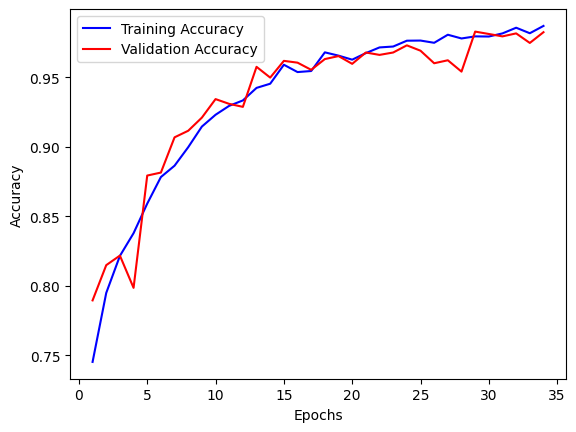

In [52]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1 ,35, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

plt.plot(np.arange(1 , 35, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()

plt.show()

In [53]:
from sklearn.metrics import classification_report

y_pred = model1.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       827
           1       0.98      0.98      0.98      2083

    accuracy                           0.98      2910
   macro avg       0.97      0.97      0.97      2910
weighted avg       0.98      0.98      0.98      2910



In [80]:
# Alterating Kernel Size: 


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=5, activation='relu')   ####
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=7, activation='relu')    ####
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.5)
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7218 - loss: 0.5851 - val_accuracy: 0.7367 - val_loss: 0.5037
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7530 - loss: 0.4837 - val_accuracy: 0.8011 - val_loss: 0.3926
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8275 - loss: 0.3729 - val_accuracy: 0.8600 - val_loss: 0.3260
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8946 - loss: 0.2786 - val_accuracy: 0.9094 - val_loss: 0.2578
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9161 - loss: 0.2395 - val_accuracy: 0.9296 - val_loss: 0.1955
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9246 - loss: 0.2120 - val_accuracy: 0.9394 - val_loss: 0.1667
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9296 - loss: 0.1860 - val_accuracy: 0.9373 - val_loss: 0.1603
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9328 - loss: 0.1755 - val_accu

In [81]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

# Greatly improved performance

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       827
           1       0.99      0.99      0.99      2083

    accuracy                           0.98      2910
   macro avg       0.98      0.98      0.98      2910
weighted avg       0.98      0.98      0.98      2910



In [56]:
# Alterating Kernel Size: ###


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=5, activation='relu')   ####
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=5, activation='relu')   ####
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.5)
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7343 - loss: 0.5633 - val_accuracy: 0.7814 - val_loss: 0.4982
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7910 - loss: 0.4348 - val_accuracy: 0.8638 - val_loss: 0.3411
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8561 - loss: 0.3510 - val_accuracy: 0.9102 - val_loss: 0.2508
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8974 - loss: 0.2724 - val_accuracy: 0.8200 - val_loss: 0.4087
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9088 - loss: 0.2429 - val_accuracy: 0.8939 - val_loss: 0.2572
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9260 - loss: 0.2003 - val_accuracy: 0.9412 - val_loss: 0.1659
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9334 - loss: 0.1800 - val_accuracy: 0.9420 - val_loss: 0.1515
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9366 - loss: 0.1735 - val_accu

In [57]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

### Results improved further

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       827
           1       0.98      0.99      0.99      2083

    accuracy                           0.98      2910
   macro avg       0.98      0.98      0.98      2910
weighted avg       0.98      0.98      0.98      2910



In [58]:
# With Oversampling with SMOTE

smo=SMOTE()
X_sm,y_sm = smo.fit_resample(X_train, y_train)
print("Klassen Anzahl y-train: ", dict(pd.Series(y_train).value_counts()))
print("Klassen Anzahl Oversampled (SMO): ", dict(pd.Series(y_sm).value_counts()))


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.5)
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_sm, y_sm, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Klassen Anzahl y-train:  {1: 8422, 0: 3218}
Klassen Anzahl Oversampled (SMO):  {1: 8422, 0: 8422}
Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6771 - loss: 0.5775 - val_accuracy: 0.8596 - val_loss: 0.4852
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8117 - loss: 0.4210 - val_accuracy: 0.8670 - val_loss: 0.3946
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8517 - loss: 0.3586 - val_accuracy: 0.4354 - val_loss: 0.8712
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.8628 - loss: 0.3140 - val_accuracy: 0.7465 - val_loss: 0.6689
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8985 - loss: 0.2453 - val_accuracy: 0.9804 - val_loss: 0.0906
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9125 - loss: 0.2198 - val_accuracy: 0.9329 - val_loss: 0.2030
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9266 - loss: 0.1814 - val_accuracy: 0.9478 - val_loss: 0.1336

In [59]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)


### Results are much Worse!

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       827
           1       0.98      0.79      0.88      2083

    accuracy                           0.84      2910
   macro avg       0.82      0.88      0.83      2910
weighted avg       0.89      0.84      0.85      2910



In [60]:
# Changing the Position of the Dropout Layer:


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)
dropout_layer = Dropout(0.5)   ####

# Dense Layers
dense_layer = Dense(50, activation='relu')
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dropout_layer(x)   ####
x = dense_layer(x)
outputs = output_layer(x)

# Modell erstellen
model1 = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model1.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7254 - loss: 0.5759 - val_accuracy: 0.7753 - val_loss: 0.4251
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7853 - loss: 0.4334 - val_accuracy: 0.8106 - val_loss: 0.3828
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8160 - loss: 0.3837 - val_accuracy: 0.7925 - val_loss: 0.4177
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8354 - loss: 0.3714 - val_accuracy: 0.8522 - val_loss: 0.3385
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8463 - loss: 0.3612 - val_accuracy: 0.8634 - val_loss: 0.3116
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8708 - loss: 0.3143 - val_accuracy: 0.8845 - val_loss: 0.2934
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8816 - loss: 0.2806 - val_accuracy: 0.8862 - val_loss: 0.3118
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8952 - loss: 0.2628 - val_accu

In [61]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

### Results are much worse

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       827
           1       0.98      0.79      0.88      2083

    accuracy                           0.84      2910
   macro avg       0.82      0.88      0.83      2910
weighted avg       0.89      0.84      0.85      2910



In [70]:
# Changing Rate of Dropout Layer: ###


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.8)     ####
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.7174 - loss: 0.5963 - val_accuracy: 0.7762 - val_loss: 0.4888
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7743 - loss: 0.4607 - val_accuracy: 0.7818 - val_loss: 0.4097
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7955 - loss: 0.4276 - val_accuracy: 0.8209 - val_loss: 0.3588
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8245 - loss: 0.3690 - val_accuracy: 0.8222 - val_loss: 0.3388
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8385 - loss: 0.3404 - val_accuracy: 0.8419 - val_loss: 0.3058
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8442 - loss: 0.3294 - val_accuracy: 0.8509 - val_loss: 0.2786
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8650 - loss: 0.2988 - val_accuracy: 0.8896 - val_loss: 0.2462
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8892 - loss: 0.2625 - val_accu

In [71]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

### Greatly improved Results

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       827
           1       0.98      0.99      0.99      2083

    accuracy                           0.98      2910
   macro avg       0.98      0.98      0.98      2910
weighted avg       0.98      0.98      0.98      2910



In [88]:
# Change of Batch Size: 


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(50, activation='relu')
dropout_layer = Dropout(0.5)   
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stopping])  ###

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7410 - loss: 0.5592 - val_accuracy: 0.7947 - val_loss: 0.4468
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8075 - loss: 0.4313 - val_accuracy: 0.8015 - val_loss: 0.4010
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8232 - loss: 0.3819 - val_accuracy: 0.8273 - val_loss: 0.3598
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8567 - loss: 0.3363 - val_accuracy: 0.8621 - val_loss: 0.3110
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8674 - loss: 0.3026 - val_accuracy: 0.8969 - val_loss: 0.2583
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8944 - loss: 0.2544 - val_accuracy: 0.9175 - val_loss: 0.2275
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9063 - loss: 0.2321 - val_accuracy: 0.9068 - val_loss: 0.2471
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9205 - loss: 0.2124 - val_acc

In [89]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

### Greatly improved Performance

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       827
           1       0.98      0.99      0.99      2083

    accuracy                           0.98      2910
   macro avg       0.98      0.97      0.98      2910
weighted avg       0.98      0.98      0.98      2910



In [92]:
# Change of Neurons in Dense Layer:

# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=3, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(100, activation='relu') ###
dropout_layer = Dropout(0.5)   
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping]) 

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7380 - loss: 0.5650 - val_accuracy: 0.7955 - val_loss: 0.4418
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8119 - loss: 0.4156 - val_accuracy: 0.8174 - val_loss: 0.3871
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8294 - loss: 0.3778 - val_accuracy: 0.8338 - val_loss: 0.3851
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8471 - loss: 0.3450 - val_accuracy: 0.7848 - val_loss: 0.4181
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8691 - loss: 0.3038 - val_accuracy: 0.8845 - val_loss: 0.3274
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8940 - loss: 0.2611 - val_accuracy: 0.8694 - val_loss: 0.2888
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8873 - loss: 0.2652 - val_accuracy: 0.8673 - val_loss: 0.2975
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9081 - loss: 0.2186 - val_accu

In [93]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

### Improved

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       827
           1       0.98      0.99      0.99      2083

    accuracy                           0.98      2910
   macro avg       0.98      0.97      0.98      2910
weighted avg       0.98      0.98      0.98      2910



### **Conclusive Model of this Exploration:** 

In [14]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer
first_layer = Conv1D(filters=64, kernel_size=5, activation='relu')
second_layer = MaxPooling1D(pool_size=2)

# Zweite CNN-Schicht hinzufügen
third_layer = Conv1D(filters=128, kernel_size=7, activation='relu')
fourth_layer = MaxPooling1D(pool_size=2)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)

# Dense Layers
dense_layer = Dense(100, activation='relu')
dropout_layer = Dropout(0.8)
output_layer = Dense(1, activation='sigmoid')

# Verbindung der Layers
x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = lstm_layer(x)
x = dense_layer(x)
x = dropout_layer(x)
outputs = output_layer(x)

# Modell erstellen
model1 = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

training_history = model1.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stopping])

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7100 - loss: 0.5842 - val_accuracy: 0.8037 - val_loss: 0.4243
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8199 - loss: 0.4101 - val_accuracy: 0.8183 - val_loss: 0.3777
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8531 - loss: 0.3529 - val_accuracy: 0.9094 - val_loss: 0.2340
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8895 - loss: 0.2767 - val_accuracy: 0.9128 - val_loss: 0.2163
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9156 - loss: 0.2269 - val_accuracy: 0.9248 - val_loss: 0.1875
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9205 - loss: 0.2142 - val_accuracy: 0.8638 - val_loss: 0.3170
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9305 - loss: 0.1929 - val_accuracy: 0.9429 - val_loss: 0.1513
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9427 - loss: 0.1563 - val_accu

In [15]:
from sklearn.metrics import classification_report

y_pred = model1.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

# Final Model of first Attempt!

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       809
           1       0.99      0.99      0.99      2101

    accuracy                           0.99      2910
   macro avg       0.99      0.99      0.99      2910
weighted avg       0.99      0.99      0.99      2910



### Second Attempt with Batch Normalization ###

In [98]:
# Second Attempt: 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer mit Batch Normalization
first_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
second_layer = BatchNormalization()(first_layer)
third_layer = MaxPooling1D(pool_size=2)(second_layer)

# Zweite CNN-Schicht hinzufügen
fourth_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(third_layer)
fifth_layer = BatchNormalization()(fourth_layer)
sixth_layer = MaxPooling1D(pool_size=2)(fifth_layer)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)(sixth_layer)

# Dense Layers
dense_layer = Dense(50, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.5)(dense_layer)

# Output Layer (binäre Klassifikation)
outputs = Dense(1, activation='sigmoid')(dropout_layer)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell-Übersicht anzeigen
model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# Modell trainieren
training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, 185, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 185, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 90, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,429 (478.24 KB)

 Trainable params: 122,045 (476.74 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7432 - loss: 0.5244 - val_accuracy: 0.7174 - val_loss: 0.5996
Epoch 2/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8674 - loss: 0.3294 - val_accuracy: 0.6482 - val_loss: 0.6097
Epoch 3/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8911 - loss: 0.2556 - val_accuracy: 0.8333 - val_loss: 0.4227
Epoch 4/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9269 - loss: 0.1932 - val_accuracy: 0.8329 - val_loss: 0.4395
Epoch 5/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9463 - loss: 0.1521 - val_accuracy: 0.7393 - val_loss: 1.0173
Epoch 6/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9570 - loss: 0.1253 - val_accuracy: 0.8930 - val_loss: 0.2610
Epoch 7/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9679 - loss: 0.0968 - val_accuracy: 0.8101 - val_loss: 0.6048
Epoch 8/50
291/291 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9710 - loss: 0.0885 - val_accu

In [99]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       827
           1       0.98      0.99      0.98      2083

    accuracy                           0.97      2910
   macro avg       0.97      0.97      0.97      2910
weighted avg       0.97      0.97      0.97      2910



In [102]:
# Second Attempt: 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# Modell Input
inputs = Input(shape=(187, 1), name="Input")

# 1D-CNN Layer mit Batch Normalization
first_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
second_layer = BatchNormalization()(first_layer)
third_layer = MaxPooling1D(pool_size=2)(second_layer)

# Zweite CNN-Schicht hinzufügen
fourth_layer = Conv1D(filters=128, kernel_size=7, activation='relu')(third_layer)
fifth_layer = BatchNormalization()(fourth_layer)
sixth_layer = MaxPooling1D(pool_size=2)(fifth_layer)

# LSTM Layer
lstm_layer = LSTM(100, return_sequences=False)(sixth_layer)

# Dense Layers
dense_layer = Dense(100, activation='relu')(lstm_layer)
dropout_layer = Dropout(0.8)(dense_layer)

# Output Layer (binäre Klassifikation)
outputs = Dense(1, activation='sigmoid')(dropout_layer)

# Modell erstellen
model = Model(inputs=inputs, outputs=outputs)

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell-Übersicht anzeigen
model.summary()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
# Modell trainieren
training_history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stopping])

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, 183, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 183, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 91, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 85, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 85, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 42, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 100)            │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,425 (626.66 KB)

 Trainable params: 160,041 (625.16 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7631 - loss: 0.5226 - val_accuracy: 0.7255 - val_loss: 0.7551
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8793 - loss: 0.3040 - val_accuracy: 0.7350 - val_loss: 0.9328
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9123 - loss: 0.2361 - val_accuracy: 0.8385 - val_loss: 0.5076
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9439 - loss: 0.1672 - val_accuracy: 0.6697 - val_loss: 1.0731
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9570 - loss: 0.1318 - val_accuracy: 0.8759 - val_loss: 0.3972
Epoch 6/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9657 - loss: 0.1157 - val_accuracy: 0.9566 - val_loss: 0.1299
Epoch 7/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9712 - loss: 0.0944 - val_accuracy: 0.8557 - val_loss: 0.5389
Epoch 8/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9727 - loss: 0.0879 - val_accu

In [103]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)

# Da die Ausgabe des Modells Wahrscheinlichkeiten zwischen 0 und 1 ist, müssen wir diese in 0 oder 1 umwandeln
y_pred_binary = (y_pred > 0.5).astype(int)

report = classification_report(y_test, y_pred_binary)

print(report)

91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       827
           1       0.98      0.98      0.98      2083

    accuracy                           0.97      2910
   macro avg       0.97      0.97      0.97      2910
weighted avg       0.97      0.97      0.97      2910

